# Data Acquisition and Cleaning
The first part of the document presents the work done in order to obtain a usable dataset. Indeed, the Million Song Dataset (MSD) was lackluster regarding song features (danceability, energy, etc), which were all set to 0. That's why we decided to take additional steps to improve this dataset.    
In the first part, we import data from the MSD and we decide to keep only some values of interest from this dataset. Next, we query the Spotify API in order to obtain additional information about each song. In the meantime, we also add genre classification for each song from 3 datasets built around the MSD. Finally, we generate a csv which will be our main resource of data for the rest of the project.

In [23]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

%load_ext autoreload
%autoreload 2

sns.set(font_scale=1.75)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The following function aims at creating a connection to an SQLite database.

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

    return None

We have a quick look at the columns we have at our disposal.

In [3]:
database = "data/track_metadata.db"
conn = create_connection(database)
cur = conn.cursor()
cur.execute("PRAGMA table_info(songs)")
rows = cur.fetchall()
print(rows)

[(0, 'track_id', 'text', 0, None, 1), (1, 'title', 'text', 0, None, 0), (2, 'song_id', 'text', 0, None, 0), (3, 'release', 'text', 0, None, 0), (4, 'artist_id', 'text', 0, None, 0), (5, 'artist_mbid', 'text', 0, None, 0), (6, 'artist_name', 'text', 0, None, 0), (7, 'duration', 'real', 0, None, 0), (8, 'artist_familiarity', 'real', 0, None, 0), (9, 'artist_hotttnesss', 'real', 0, None, 0), (10, 'year', 'int', 0, None, 0)]


Request the dataset and put the data in a dataframe.

In [4]:
cur.execute("SELECT track_id, song_id, artist_id, duration, artist_hotttnesss, year FROM songs ORDER BY track_id")
rows = cur.fetchall()
songs = pd.DataFrame(rows, columns=['track_id', 'song_id', 'artist_id', 'duration', 'artist_hotttnesss', 'year'])

The 3 following cells merge our data from genres classification coming from 3 datasets.

In [5]:
track_genre_cd1 = pd.read_csv('data/msd_tagtraum_cd1.cls', sep='\t', names=['track_id', 'genre1_cd1', 'genre2_cd1'])
songs = track_genre_cd1.merge(songs, on='track_id', how='right')

In [6]:
track_genre_cd1 = pd.read_csv('data/msd_tagtraum_cd2.cls', sep='\t', names=['track_id', 'genre1_cd2', 'genre2_cd2'])
songs = track_genre_cd1.merge(songs, on='track_id', how='right')

In [7]:
track_genre_cd1 = pd.read_csv('data/msd_tagtraum_cd2c.cls', sep='\t', names=['track_id', 'genre1_cd2c', 'genre2_cd2c'])
songs = track_genre_cd1.merge(songs, on='track_id', how='right')

We take a look at the analysis of the songs from the MSD

In [8]:
msd_summary_file = pd.HDFStore("data/msd_summary_file.h5")
songs_analysis = msd_summary_file.get('/analysis/songs')
songs_analysis.columns

Index(['analysis_sample_rate', 'audio_md5', 'danceability', 'duration',
       'end_of_fade_in', 'energy', 'idx_bars_confidence', 'idx_bars_start',
       'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence',
       'idx_sections_start', 'idx_segments_confidence',
       'idx_segments_loudness_max', 'idx_segments_loudness_max_time',
       'idx_segments_loudness_start', 'idx_segments_pitches',
       'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence',
       'idx_tatums_start', 'key', 'key_confidence', 'loudness', 'mode',
       'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature',
       'time_signature_confidence', 'track_id'],
      dtype='object')

And add the data we find interesting. Indeed a lot of columns in this dataset are empty and cannot be used.

In [9]:
songs_analysis = songs_analysis[['track_id', 'loudness', 'mode', 'tempo', 'key']]
songs = songs_analysis.merge(songs, on='track_id')
del(songs_analysis)

We do the same operation for the metadata.

In [10]:
songs_metadata = msd_summary_file.get('/metadata/songs')
songs_metadata.columns

Index(['analyzer_version', 'artist_7digitalid', 'artist_familiarity',
       'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location',
       'artist_longitude', 'artist_mbid', 'artist_name', 'artist_playmeid',
       'genre', 'idx_artist_terms', 'idx_similar_artists', 'release',
       'release_7digitalid', 'song_hotttnesss', 'song_id', 'title',
       'track_7digitalid'],
      dtype='object')

In [11]:
songs_metadata = songs_metadata[['song_hotttnesss', 'song_id', 'artist_latitude', 'artist_location', 'artist_longitude']]
songs = songs_metadata.merge(songs, on='song_id')
del(songs_metadata)

And we take a look at the data we have gathered until now.

In [12]:
songs.head()

song_hotttnesss             song_id  artist_latitude    artist_location  \
0         0.542899  SOQMMHC12AB0180CB8              NaN                      
1         0.299877  SOVFVAK12A8C1350D9              NaN                      
2         0.617871  SOGTUKN12AB017F4F1          55.8578  Glasgow, Scotland   
3              NaN  SOBNYVR12A8C13558C              NaN                      
4              NaN  SOHSBXH12A8C13B0DF              NaN                      

   artist_longitude            track_id  loudness  mode    tempo  key  \
0               NaN  TRMMMYQ128F932D901    -4.829     0   87.002   10   
1               NaN  TRMMMKD128F425225D   -10.555     1  150.778    9   
2          -4.24251  TRMMMRX128F93187D9    -2.060     1  177.768    7   
3               NaN  TRMMMCH128F425532C    -4.654     1   87.433    7   
4               NaN  TRMMMWA128F426B589    -7.806     0  140.035    5   

  genre1_cd2c  genre2_cd2c  genre1_cd2 genre2_cd2  genre1_cd1 genre2_cd1  \
0         NaN          NaN         NaN        NaN         NaN        NaN   
1         NaN          NaN         NaN        NaN         NaN        NaN   
2         NaN          NaN  Electronic        Rap  Electronic        Rap   
3         NaN          NaN         NaN        NaN         NaN        NaN   
4         NaN          NaN         NaN        NaN         NaN        NaN   

            artist_id   duration  artist_hotttnesss  year  
0  ARYZTJS1187B98C555  252.05506           0.394032  2003  
1  ARMVN3U1187FB3A1EB  156.55138           0.356992  1995  
2  ARGEKB01187FB50750  138.97098           0.437504  2006  
3  ARNWYLR1187B9B2F9C  145.05751           0.372349  2003  
4  AREQDTE1269FB37231  514.29832           0.000000     0

In order to gather data from the Spotify API we have some scripts in auxiliary files (stored in the folder spotify_requests_tools). Using these tools, we created two csv 'feature_songs.csv' and 'track_year_popularity.csv' which contain additional information for each song.

In [13]:
spotify_data = pd.read_csv('data/feature_songs.csv')
spotify_data.columns

Index(['song_id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms'],
      dtype='object')

In [14]:
# Replace the unknown values(zeros) by NaN
for column in spotify_data.columns:
    spotify_data.loc[spotify_data[column] == 0, column] = np.nan

In [15]:
songs2 = songs.merge(spotify_data, how='left', on='song_id')

Again taking a look at the data we have until now

In [16]:
songs2.head()

song_hotttnesss             song_id  artist_latitude    artist_location  \
0         0.542899  SOQMMHC12AB0180CB8              NaN                      
1         0.299877  SOVFVAK12A8C1350D9              NaN                      
2         0.617871  SOGTUKN12AB017F4F1          55.8578  Glasgow, Scotland   
3              NaN  SOBNYVR12A8C13558C              NaN                      
4              NaN  SOHSBXH12A8C13B0DF              NaN                      

   artist_longitude            track_id  loudness_x  mode_x  tempo_x  key_x  \
0               NaN  TRMMMYQ128F932D901      -4.829       0   87.002     10   
1               NaN  TRMMMKD128F425225D     -10.555       1  150.778      9   
2          -4.24251  TRMMMRX128F93187D9      -2.060       1  177.768      7   
3               NaN  TRMMMCH128F425532C      -4.654       1   87.433      7   
4               NaN  TRMMMWA128F426B589      -7.806       0  140.035      5   

      ...      key_y  loudness_y mode_y speechiness acousticness  \
0     ...        NaN         NaN    NaN         NaN          NaN   
1     ...        9.0     -10.303    1.0      0.0462     0.002230   
2     ...        4.0      -1.711    NaN      0.0662     0.000045   
3     ...        7.0      -4.302    1.0      0.1470     0.130000   
4     ...        NaN         NaN    NaN         NaN          NaN   

  instrumentalness liveness  valence  tempo_y  duration_ms  
0              NaN      NaN      NaN      NaN          NaN  
1            0.090   0.0869    0.880  149.971     157933.0  
2            0.952   0.3430    0.621  177.745     138960.0  
3              NaN   0.1150    0.962  174.013     145032.0  
4              NaN      NaN      NaN      NaN          NaN  

[5 rows x 32 columns]

In [17]:
songs2.iloc[1, :]

song_hotttnesss                0.299877
song_id              SOVFVAK12A8C1350D9
artist_latitude                     NaN
artist_location                        
artist_longitude                    NaN
track_id             TRMMMKD128F425225D
loudness_x                      -10.555
mode_x                                1
tempo_x                         150.778
key_x                                 9
genre1_cd2c                         NaN
genre2_cd2c                         NaN
genre1_cd2                          NaN
genre2_cd2                          NaN
genre1_cd1                          NaN
genre2_cd1                          NaN
artist_id            ARMVN3U1187FB3A1EB
duration                        156.551
artist_hotttnesss              0.356992
year                               1995
danceability                      0.489
energy                            0.583
key_y                                 9
loudness_y                      -10.303
mode_y                                1


In [18]:
spotify_year_pop = pd.read_csv('data/track_year_popularity.csv')
final_merge = songs2.merge(spotify_year_pop.drop_duplicates(['song_id'], keep='last'), how='left', on='song_id')

Finally we take a look at our data and save them into a csv file.

In [19]:
final_merge.columns

Index(['song_hotttnesss', 'song_id', 'artist_latitude', 'artist_location',
       'artist_longitude', 'track_id', 'loudness_x', 'mode_x', 'tempo_x',
       'key_x', 'genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2',
       'genre1_cd1', 'genre2_cd1', 'artist_id', 'duration',
       'artist_hotttnesss', 'year', 'danceability', 'energy', 'key_y',
       'loudness_y', 'mode_y', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms',
       'track_popularity', 'album_release'],
      dtype='object')

In [20]:
final_merge.to_csv('final_merge.csv')

In [21]:
final_merge.shape

(1007807, 34)

It seems that we have gained some rows while joining the datasets. This may be due to duplicate IDs.

In [22]:
final_merge.loc[2,:]

song_hotttnesss                0.617871
song_id              SOGTUKN12AB017F4F1
artist_latitude                 55.8578
artist_location       Glasgow, Scotland
artist_longitude               -4.24251
track_id             TRMMMRX128F93187D9
loudness_x                        -2.06
mode_x                                1
tempo_x                         177.768
key_x                                 7
genre1_cd2c                         NaN
genre2_cd2c                         NaN
genre1_cd2                   Electronic
genre2_cd2                          Rap
genre1_cd1                   Electronic
genre2_cd1                          Rap
artist_id            ARGEKB01187FB50750
duration                        138.971
artist_hotttnesss              0.437504
year                               2006
danceability                      0.662
energy                            0.823
key_y                                 4
loudness_y                       -1.711
mode_y                              NaN


# Feature analysis

In [24]:
df = pd.read_csv('final_merge.csv')
df['song_hotttnesss'] = df['song_hotttnesss'].fillna(0.0)

Let's put the dataframe in a good form for the rest of the analysis.

First, we remove all useless column, or the one we don't want to describe a song.

In [25]:
df.columns

Index(['Unnamed: 0', 'song_hotttnesss', 'song_id', 'artist_latitude',
       'artist_location', 'artist_longitude', 'track_id', 'loudness_x',
       'mode_x', 'tempo_x', 'key_x', 'genre1_cd2c', 'genre2_cd2c',
       'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1', 'artist_id',
       'duration', 'artist_hotttnesss', 'year', 'danceability', 'energy',
       'key_y', 'loudness_y', 'mode_y', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms',
       'track_popularity', 'album_release'],
      dtype='object')

In [26]:
df_stage1 = df.drop(['Unnamed: 0', 'artist_latitude', 'artist_location', 'artist_id', 'artist_longitude', 'song_id', 'track_id', 'artist_hotttnesss', 'mode_x', 'mode_y'], axis=1)

We will need a one hot encoded matrix for genre for future analysis. We need all the genres in a first time.

In [27]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df_stage1[col_name].unique())
print(genres)
print(len(genres))

{nan, nan, 'RnB', 'Pop', 'Folk', 'Reggae', 'Rock', 'Country', 'Blues', 'Punk', 'World', 'Rap', 'Pop_Rock', 'Latin', 'New Age', 'Jazz', 'Vocal', 'Metal', 'Electronic', 'International'}
20


We have 17 different genres (nan are unkownn and international is the same as world). To do a meaningful analysis of the genre analysis over the year a minimum amount of songs of the analyzed type must be in the dataset. In the following cells we first replace the nan and replace International by World. 

In [28]:
df_stage1[genres_cols] = df_stage1[genres_cols].fillna('Unknown')
df_stage1[genres_cols] = df_stage1[genres_cols].replace('International', 'World')

Let's just check that we have the wanting form

In [29]:
df_stage1[genres_cols].head()

genre1_cd2c genre2_cd2c  genre1_cd2 genre2_cd2  genre1_cd1 genre2_cd1
0     Unknown     Unknown     Unknown    Unknown     Unknown    Unknown
1     Unknown     Unknown     Unknown    Unknown     Unknown    Unknown
2     Unknown     Unknown  Electronic        Rap  Electronic        Rap
3     Unknown     Unknown     Unknown    Unknown     Unknown    Unknown
4     Unknown     Unknown     Unknown    Unknown     Unknown    Unknown

For the moment we have 6 columns for the genres, we would like to see if we can summarize these columns in one or two columns.
First we perform a pivot and count the number of different values there are in each column. 

In [30]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df_stage1[col_name].unique())
    df_stage1[col_name] = df_stage1[col_name].astype(str)
print(genres)
print(len(genres))

{'RnB', 'Pop', 'Unknown', 'Folk', 'Reggae', 'Rock', 'Country', 'Blues', 'Punk', 'World', 'Rap', 'Pop_Rock', 'Latin', 'New Age', 'Jazz', 'Vocal', 'Metal', 'Electronic'}
18


In [31]:
for genre in list(genres):
    df_stage1[genre] = 0
    for col_name in genres_cols:
        df_stage1.loc[df_stage1[col_name] == genre, genre] = 1
df_stage1.drop(columns=['Unknown'], axis=1, inplace=True)
genres.remove('Unknown')

Let's make sure we have a hot encoded matrix at the end now

In [32]:
df_stage2 = df_stage1.drop(genres_cols, axis=1).copy()
df_stage2.head()

song_hotttnesss  loudness_x  tempo_x  key_x   duration  year  danceability  \
0         0.542899      -4.829   87.002     10  252.05506  2003           NaN   
1         0.299877     -10.555  150.778      9  156.55138  1995         0.489   
2         0.617871      -2.060  177.768      7  138.97098  2006         0.662   
3         0.000000      -4.654   87.433      7  145.05751  2003         0.690   
4         0.000000      -7.806  140.035      5  514.29832     0           NaN   

   energy  key_y  loudness_y     ...      Punk  World  Rap  Pop_Rock  Latin  \
0     NaN    NaN         NaN     ...         0      0    0         0      0   
1   0.583    9.0     -10.303     ...         0      0    0         0      0   
2   0.823    4.0      -1.711     ...         0      0    1         0      0   
3   0.619    7.0      -4.302     ...         0      0    0         0      0   
4     NaN    NaN         NaN     ...         0      0    0         0      0   

   New Age  Jazz  Vocal  Metal  Electronic  
0        0     0      0      0           0  
1        0     0      0      0           0  
2        0     0      0      0           1  
3        0     0      0      0           0  
4        0     0      0      0           0  

[5 rows x 36 columns]

Now that the matrix is ready, let's see if we can spot something from a simple correlation between the data, especially between song_hotttnesss and the rest of the features.

In [33]:
def plot_corr(df, output_file_name):
    '''
        Plot the correlation matrix of a dataframe
        The plot will be triangular with negative values blue and positive values red
        Code taken from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        :param df: The dataframe
        :type df: DataFrame
    '''
    sns.set(style="white", font_scale=1.5)

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 12))
    f.suptitle("Correlation heatmap")

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    snsplot = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    snsplot.figure.savefig(output_file_name)


A final remark about song year. Most of them are in fact 0:

In [34]:
df_stage2[df_stage2.year == 0].year.count()

487428

Let's remove them for the correlation.

In [35]:
plot_corr(df_stage2[df_stage2.year != 0][df_stage2.columns[0:-17]], "datastory/figures/feature/correlationComplete.png")

What do we see here ?

1) the value between spotify and MSD on the duration is highly correlated, same for loudness and key, so let's keep the original one 

2) track_popularity and song_hotttnesss is moderately correlated, thus we will keep the song_hotttnesss

3) year of MSD and album release from spotify is absolutely not correlated, so let's keep the one from MSD again

4) The acousticness has negative correlation with loudness and energy (which seems logical, as classical music is generally not loud or energetic)

5) no feature looks highly, even moderately, correlated to the song_hotttnesss

Let's drop the useless columns again

In [36]:
df_stage3 = df_stage2.drop(['album_release', 'track_popularity', 'duration_ms', 'key_y', 'loudness_y', 'tempo_x'], axis=1)
df_stage3.rename(columns={'key_x': 'key', 'loudness_x': 'loudness', 'tempo_y': 'tempo'}, inplace=True)

In [37]:
plot_corr(df_stage3[df_stage3.year != 0][df_stage3.columns[0:-17]], "datastory/figures/feature/correlationReduce.png")

And let's do the same thing for genre only.

In [38]:
plot_corr(pd.concat([df_stage3[['song_hotttnesss']],df_stage3[df_stage3.columns[-17:]]], axis=1), "datastory/figures/feature/correlationGenre.png")

We want know to check if we can train a regressor and export the features importance. Here we use an RandomForest like in HW4, but a regressor one this time.

In [39]:
regressor = RandomForestRegressor(n_jobs=-1, n_estimators = 400, verbose=True)

df_stage4 = df_stage3.copy()
df_stage4 = df_stage4.dropna(axis=0, how='any')
df_stage4 = df_stage4[df_stage4.year > 0]
df_stage4['nb_genre'] = np.sum(df_stage4.iloc[:, -17:].values, axis=1)  
df_stage4 = df_stage4[df_stage4.nb_genre > 0].drop(['nb_genre'], axis=1)

train_set = df_stage4.drop(['song_hotttnesss'], axis=1)  

train_label = df_stage4.song_hotttnesss

regressor.fit(train_set, train_label)   

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=None, verbose=True,
           warm_start=False)

Let's check the importance per feature, in order to extract some useful insights. 

Note that we sum the importance of each genre to see what they mean for the whole random forest, as we can sum feature to get the importance of a bag of feature.

In [40]:
genre_sum = 0.0
for a, b in sorted(zip(regressor.feature_importances_, train_set.columns), reverse=True):
    print(a, " : ", b)
    if b in genres:
        genre_sum += a
        
genre_sum

0.0931246038967  :  liveness
0.0886792373482  :  year
0.0873846033956  :  duration
0.0808249814771  :  acousticness
0.0799274300456  :  danceability
0.0795074830632  :  loudness
0.0787966164426  :  valence
0.0786248277777  :  tempo
0.0785361774598  :  instrumentalness
0.0757446803428  :  speechiness
0.0697492055045  :  energy
0.0387396465685  :  key
0.00982917777166  :  Pop_Rock
0.0089211418065  :  Rock
0.00730479335881  :  Pop
0.00679510523245  :  Metal
0.0052735129575  :  Electronic
0.00368064631412  :  Jazz
0.00350550441656  :  Folk
0.00347094480589  :  Country
0.00343074363356  :  Blues
0.00327866662985  :  RnB
0.0030490706142  :  Latin
0.00248261271426  :  Rap
0.00231561510696  :  Reggae
0.00231014128379  :  World
0.00207715803137  :  Punk
0.00182884497971  :  New Age
0.000806827020629  :  Vocal


0.070360506677826909

Note that, with a sum of 0.07, the bagging of the genres has the same importance as the others.

It looks like we have some really interesting features, but let's create a graph to visualize it.

In [41]:
feature_importance_df = pd.DataFrame({'label': train_set.columns, 'feature_importance' : regressor.feature_importances_})
feature_importance_df = feature_importance_df.sort_values('feature_importance', ascending=False).iloc[:13]
feature_importance_df.iloc[12] = [genre_sum, 'genre']

order = np.flipud(feature_importance_df.sort_values(by='feature_importance').label)

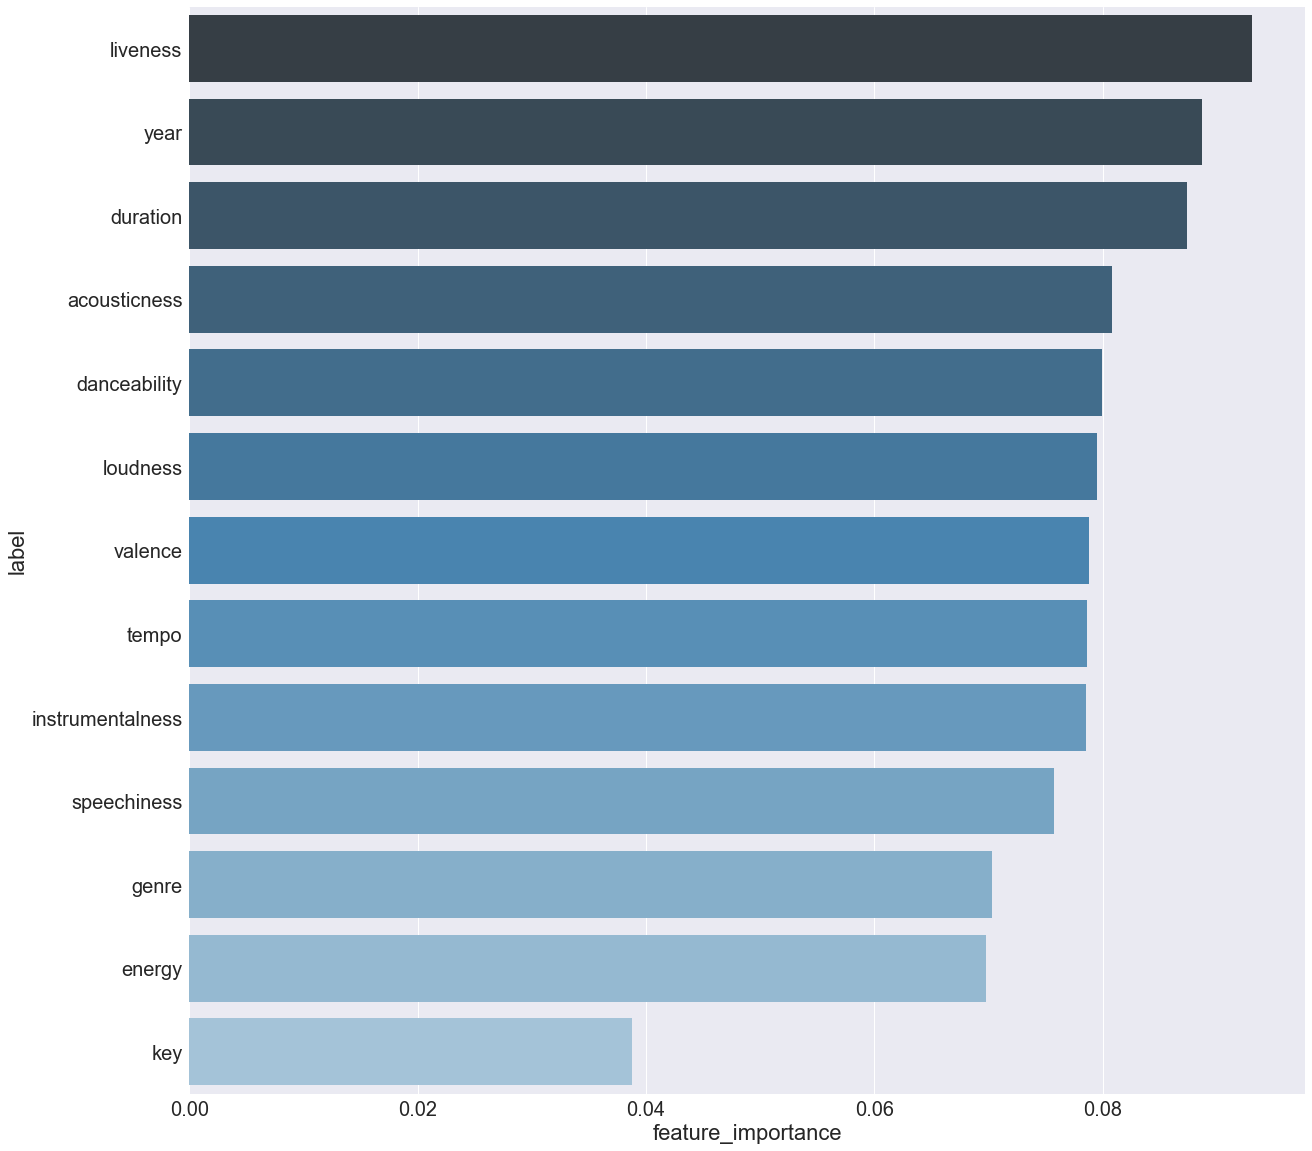

In [42]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(20,20))

snsplot = sns.barplot(x='feature_importance', y='label', data=feature_importance_df, palette="Blues_d", order=order)

snsplot.figure.savefig("datastory/figures/feature/RandomForest_feature_importance.png")

In [43]:
def plot_scatter(df, y_name, x_name):
    sns_plot = sns.lmplot(x=x_name, y=y_name, scatter_kws={"s": 2}, line_kws={'color': 'red'}, data=df)
    sns_plot.savefig("datastory/figures/scatter_feature/scatter_" + x_name + ".png")

In [44]:
df_with_correct_feature = df_stage3.dropna(axis=0, how='any').copy()

df_with_correct_year = df_stage3[df_stage3.year > 0].copy()

df_with_correct_genre = df_stage3.copy()
df_with_correct_genre['nb_genre'] = np.sum(df_with_correct_genre.iloc[:, -17:].values, axis=1)  
df_with_correct_genre = df_with_correct_genre[df_with_correct_genre.nb_genre > 0].drop(['nb_genre'], axis=1)
   
print("correct feature len: ", len(df_with_correct_feature))
print("correct year len: ", len(df_with_correct_year))
print("correct genre len: ", len(df_with_correct_genre))

correct feature len:  328046
correct year len:  520379
correct genre len:  288151


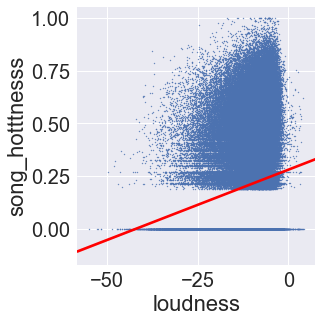

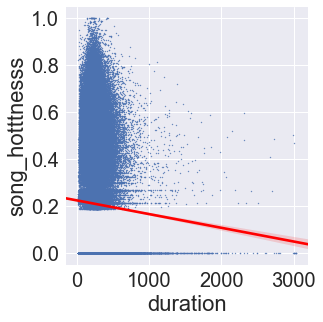

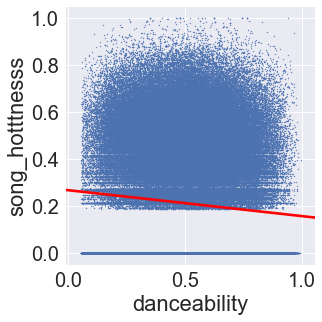

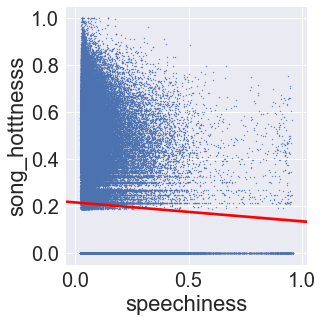

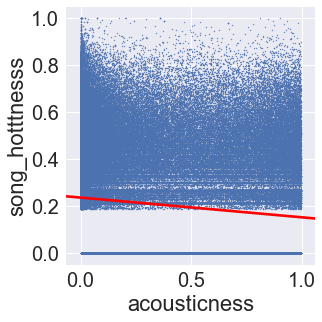

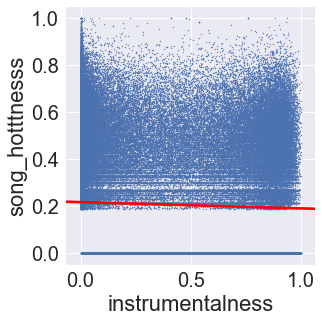

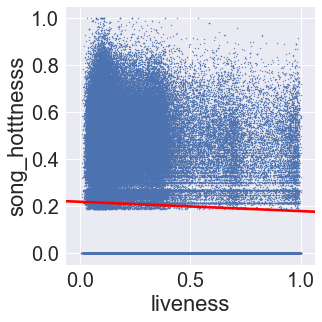

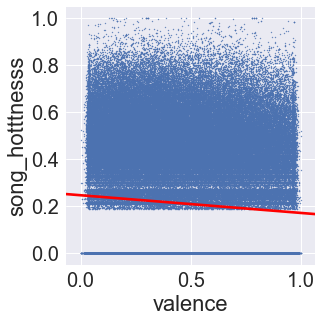

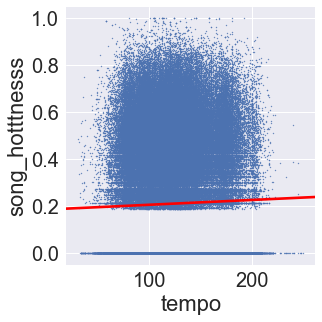

In [45]:
for feature in df_with_correct_feature.columns[:-17]:
    if feature != "year" and feature != "song_hotttnesss":
        plot_scatter(df_with_correct_feature, "song_hotttnesss", feature)

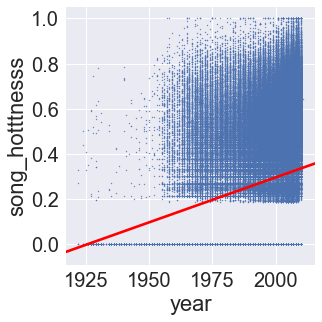

In [46]:
plot_scatter(df_with_correct_year, "song_hotttnesss", "year")

# Year analysis

In [47]:
df = pd.read_csv('final_merge.csv')
df['album_release'] = df['album_release'].fillna(0).astype(int) #must fill nan with value to convert to int
df = df.loc[df['year'] != 0] #don't take 0, as it means unknown
df.describe()

Unnamed: 0  song_hotttnesss  artist_latitude  artist_longitude  \
count  5.203790e+05    349099.000000    188960.000000     188960.000000   
mean   5.032707e+05         0.431690        39.934698        -54.412027   
std    2.908924e+05         0.214983        15.701568         56.035174   
min    0.000000e+00         0.000000       -51.800580       -159.540540   
25%    2.511270e+05         0.304170        35.149680        -90.180490   
50%    5.030970e+05         0.459725        40.714550        -75.162370   
75%    7.548480e+05         0.582811        50.848380         -1.546580   
max    1.007806e+06         1.000000        70.695760        178.690960   

          loudness_x         mode_x        tempo_x          key_x  \
count  520379.000000  520379.000000  520379.000000  520379.000000   
mean       -9.693092       0.663566     124.785756       5.315261   
std         4.938521       0.472490      34.854771       3.600813   
min       -57.004000       0.000000       0.000000       0.000000   
25%       -12.167000       0.000000      99.002000       2.000000   
50%        -8.608000       1.000000     122.486000       5.000000   
75%        -6.124000       1.000000     145.256500       9.000000   
max         4.150000       1.000000     280.955000      11.000000   

       genre2_cd2c       duration      ...          mode_y    speechiness  \
count          0.0  520379.000000      ...        146243.0  219885.000000   
mean           NaN     246.792014      ...             1.0       0.082549   
std            NaN     115.333437      ...             0.0       0.110330   
min            NaN       0.313020      ...             1.0       0.021600   
25%            NaN     183.196280      ...             1.0       0.034400   
50%            NaN     229.929340      ...             1.0       0.045700   
75%            NaN     286.980770      ...             1.0       0.077400   
max            NaN    3024.665670      ...             1.0       0.969000   

        acousticness  instrumentalness       liveness        valence  \
count  219942.000000     175752.000000  219979.000000  219876.000000   
mean        0.283646          0.254747       0.224016       0.488946   
std         0.327752          0.350219       0.203055       0.262209   
min         0.000001          0.000001       0.008600       0.000010   
25%         0.007250          0.000175       0.097400       0.273000   
50%         0.116000          0.016000       0.136000       0.486000   
75%         0.538000          0.573000       0.292000       0.703000   
max         0.996000          0.999000       1.000000       1.000000   

             tempo_y   duration_ms  track_popularity  album_release  
count  219885.000000  2.199850e+05     219841.000000  520379.000000  
mean      121.642483  2.394201e+05          4.899527     845.338449  
std        29.419634  1.043991e+05          8.608010     988.505496  
min        30.716000  4.000000e+03          0.000000       0.000000  
25%        98.943000  1.822930e+05          0.000000       0.000000  
50%       120.099000  2.274670e+05          0.000000       0.000000  
75%       139.709000  2.793070e+05          6.000000    2002.000000  
max       246.830000  3.005613e+06         73.000000    2016.000000  

[8 rows x 26 columns]

We can see that we still have more than 500k tracks to do our year/time analysis, which should be enough to see correlations if there are any.

In [50]:
df_c = df.copy()

year_plot = df_c.groupby('year').size().plot(kind='bar', figsize=(16,12), color='g')
ax = plt.gca()
for label in ax.get_xticklabels(): #Little trick to avoid cluttering the x axis and only see every 5 years
    label.set_visible(False)
for label in ax.get_xticklabels()[2::5]:
    label.set_visible(True)
ax.set_ylabel("Number of samples")
fig = plt.gcf()
fig.suptitle("Samples per year", y=0.9)
fig.savefig("datastory/figures/year_analysis_plots/samples_per_year.png", bbox_inches='tight')

## Analysis

We can see, as expected, that the dataset doesn't have many songs before ~1990. It also stops after 2010 (when the dataset got created). The set is therefore not sampled uniformly on the release date. Indeed, as explained on the MSD website, the dataset was chosen using the most popular artist / tracks, which explains why older songs are underrepresented.

In [51]:
def plot_by(df, idx, column, ax=None):
    '''
        Plot a column (y axis) against an index (x axis)
        Will generate a plot matching for each idx value the mean of the column value for this idx.
        :param df: The dataframe containing the data
        :param idx: The x axis series
        :param column: the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type idx: string
        :type column: string
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[[idx,column]]
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(idx)
    axes.set_ylabel(column)
    df_c.groupby([idx]).mean().plot(ax=ax)
    
def plot_by_year(df, column, ax = None):
    '''
        Plot a column (y axis) against the year (x axis)
        Will generate a plot matching for each year the mean of the column value for this year.
        :param df: The dataframe containing the data
        :param column: the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column: string
        :type ax: Axes
    '''
    plot_by(df,'year',column, ax=ax)
    
def plot_heatmap_by(df, idx, column, ax = None):
    '''
        Plot a heatmap using an index (x axis), and a column (y axis)
        The color value of the heatmap will be the number of samples for this coordinate.
        :param df: The dataframe containing the data
        :param idx: the name of the x axis series
        :param column: the name of the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type idx: string
        :type column: string
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[[idx,column]]
    if df[column].dtype == np.float or df[column].dtype == np.float64: #Bin the data if needed
        bins = np.linspace(df[column].min(),df[column].max(),20)
        df_c[column] = pd.cut(df_c[column],bins)
    df_c = df_c.dropna()
    df_count = pd.DataFrame(df_c.groupby([idx, column]).size().rename('count'))
    df_c = df_c.join(df_count, on=[idx,column])
    df_c = df_c.reset_index().pivot_table(index=idx, columns=column, values='count', aggfunc='mean')
    if ax==None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(idx)
    axes.set_ylabel(column)
    sns.heatmap(df_c, ax=ax, cbar_kws={'label': 'Number of samples'})

def plot_heatmap_by_year(df, column, ax=None):
    '''
        Plot a heatmap using a column (y axis) against the years
        The color value of the heatmap will be the number of samples for this coordinate.
        :param df: The dataframe containing the data
        :param column: the name of the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column: string
        :type ax: Axes
    '''
    plot_heatmap_by(df, 'year', column, ax=ax)
    
def plot_for_year(df, column, year, ax=None, decade=False):
    '''
        Plot a stripplot (lineplot) of a feature / column for a given year against the song_hotttnesss
        The plot will have jitter to better visualize the data
        :param df: The dataframe containing the data
        :param column: the name of the series
        :param year: the year
        :param ax: A custom axis object to plot on
        :param decade: Whether to consider the whole decade or not
        :type df: DataFrame
        :type column: string
        :type year: int
        :type ax: Axes
        :type decade: boolean
    '''
    df_c = df.copy()
    if decade:
        df_c['year'], bins=pd.cut(df_c['year'],range(1960,2020,10), include_lowest=True, retbins=True)
        interval = pd.Interval(year, year+10)
        df_c = df_c[interval==df_c['year']]
    else:
        df_c = df_c[df_c['year']==year]
    df_c = df_c[[column, 'song_hotttnesss']]
    df_c['song_hotttnesss'], bins = pd.cut(df_c['song_hotttnesss'],np.linspace(0,1,11), retbins=True) #Bin the song hotness
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax

    axes.set_xlim(df[column].min()-0.1,df[column].max()+0.1)
    axes.set_xlabel(column)
    axes.set_ylabel(year)
    sns.stripplot(x=column, y='song_hotttnesss',data=df_c, jitter=0.5, ax=axes)
    axes.invert_yaxis()
    min_y = axes.get_ylim()[0]
    max_y = axes.get_ylim()[1]
    length = max_y-min_y
    for hotness in df_c['song_hotttnesss'].unique(): #Plot the mean of each song hotness bin
        if type(hotness)==pd.Interval:
            median = df_c.loc[df_c['song_hotttnesss']==hotness][column].median()
            start = hotness.left
            end = hotness.right
            axes.plot([median,median], [length*start+min_y, length*end+min_y], color='k', zorder=1000)
    
    
def plot_heatmap_for_year(df, column1, column2, year, ax=None):
    '''
        Plot a kdeplot of two features / columns for a given year
        It will allow to see correlation between the two columns
        :param df: The dataframe containing the data
        :param column1: the name of the first series
        :param column2: the name of the second series
        :param year: the year
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column1: string
        :type column2: string
        :type year: int
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[df_c['year']==year]
    df_c = df_c[[column1, column2]]
    df_c = df_c.dropna()
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(column1)
    axes.set_ylabel(column2)
    sns.kdeplot(df_c[column1], df_c[column2], cmap="Reds", shade=True, shade_lowest=False, ax=axes)

def ceil(x):
    '''
        Shortcut for np.ceil(x).astype(int)
        :param x: the value to ceil
        :type x: number
        :return: The result of the ceiling as an int
        :rtype: int
    '''
    return np.ceil(x).astype(int)

We select the features which make sense and then plot their evolution through the years

In [52]:
selected = ['song_hotttnesss', 'loudness_x', 'mode_x', 'tempo_x', 'key_x', 'duration', 'artist_hotttnesss', 'danceability', 'energy', 'key_y', 'loudness_y', 'mode_y', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms']
selected.sort()

n_cols = 4
n_rows = ceil(len(selected)/n_cols)
fig, ax = plt.subplots(n_rows,n_cols)
fig.set_size_inches(20,n_rows*20/n_cols)
idx_r = 0
idx_c = 0

#For each feature, plot the mean of the feature for each year
for col in selected:
    plot_by_year(df,col,ax=ax[idx_r, idx_c])
    if idx_c==n_cols-1:
        idx_r+=1
        idx_c=0
    else:
        idx_c+=1

## Analysis

For most of the data before ~1960, there is a huge variance due to the low number of samples. However, we can still see tendencies for several features.    
- Duration : We can see a clear spike (for both duration and duration_ms) around 1960. We suppose that it is due to the apparition and democratization of the vinyl record (more precisely its more modern iteration). This allowed the musicians to store longer musics (which seemed to be a problem before). However, the duration hasn't increased since, probably because the artists and public feel that the current mean duration is the most optimal one.

- Acousticness : We see a massive drop through the years. This is surely due to the apparition of the electronic music (acousticness is determined by the absence of electronic instruments).

- Loudness : The music seems to get louder and louder. This is probably due to cultural changes (genre, etc).

- Energy : The energy also increases along with the loudness.

- Song hotness : The hotness seems to spike at around 2010. This may be explained by the algorithm, if it is similar to the one of Spotify, the hotness is hugely influenced by the recency of the music, which explains this result. Otherwise, this may be due to the same problem seen with tempo, mode, etc, which all spike at the end of the graph.

- We can drop mode_y, as it is always 1.

- We can't really say much about the other values, except that they seem to stay stable through the years.

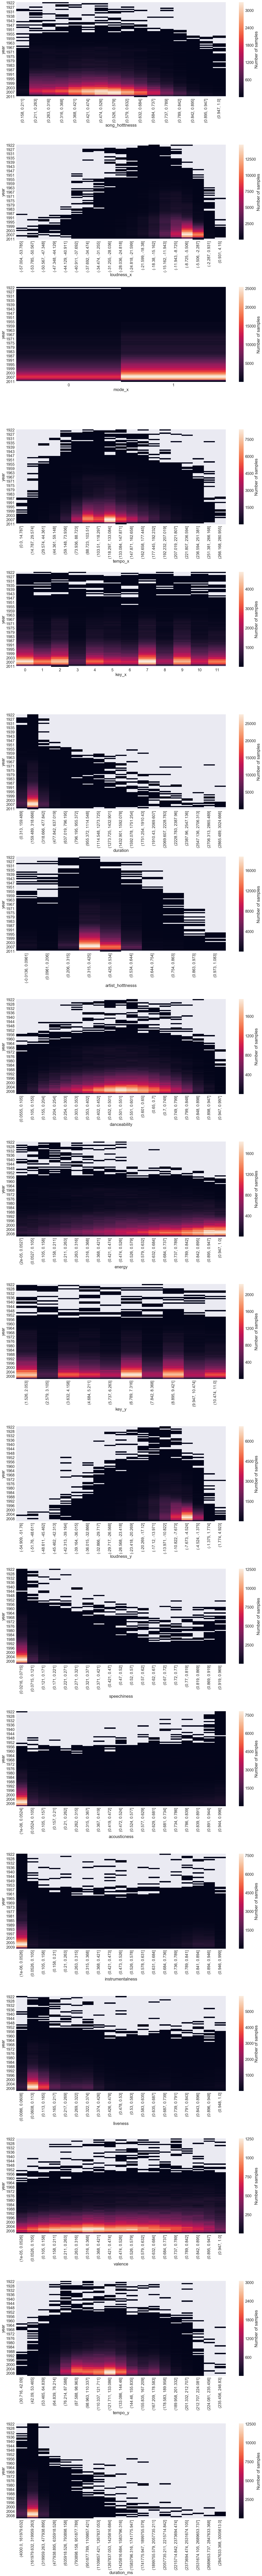

In [53]:
n_cols = 1
selected = ['song_hotttnesss', 'loudness_x', 'mode_x', 'tempo_x', 'key_x', 'duration', 'artist_hotttnesss', 'danceability', 'energy', 'key_y', 'loudness_y', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms']
n_rows = ceil(len(selected)/n_cols)
fig, ax = plt.subplots(n_rows,n_cols)
fig.set_size_inches(20,n_rows*20/n_cols/2) #Trying to find a good aspect
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

#For each feature, print the heatmap of the feature regarding the year
for idx,col in enumerate(selected):
    plot_heatmap_by_year(df, col, ax=ax[idx])

## Analysis
These graphs don't show much, except that most of the samples are recent, as seen earlier (and what feature values those recent years samples have). We could perhaps normalize by year to have a better visualization.

### You will need the ipython extensions / widgets enabled to use the interactive graph below

In [57]:
df_c = df.copy()
df_c = df_c[df_c['year']>=1960] #Only take after 1960, as before there are very few samples
DECADE = "Decade"
SINGLE_YEAR = "Single year"
df_c['artist_hotttnesss'][df_c['artist_hotttnesss']<0]=0 # Clamp the artist hotness as the data is sometimes faulty
df_c['artist_hotttnesss'][df_c['artist_hotttnesss']>1]=1
decades = widgets.RadioButtons( #Button to select year or decade
options=[DECADE,SINGLE_YEAR],value=SINGLE_YEAR, disabled=False, description="Year grouping")
year = widgets.BoundedIntText( #Field to select year
    value=1960,
    min=1960,
    max=2010,
    step=1,
    description='Year:',
    disabled=False,
    color='black'
)
def update_year(*args):
    """
    Update the year widget depending on the button value
    """
    if decades.value==SINGLE_YEAR:
        year.step=1
        year.max=2010
        year.description='Year:'
    else:
        year.step=10
        year.value=np.round(year.value/10)*10
        year.max=2000
        year.description="Decade:"
    
decades.observe(update_year,'value') #Listener

feature = widgets.Dropdown( #Widget to select the feature
    options=selected[1:], #Don't take song hotness
    value='loudness_x',
    description='Feature:',
)

def save_all_plots():
    """
    Saves all the year stripplots
    """
    for f in selected[1:]:
        for year in range(1960, 2011):
            plotit(f, year, SINGLE_YEAR)
            fig = plt.gcf()
            fig.savefig("datastory/figures/year_analysis_plots/single_year/"+f+"_"+str(year)+".png", bbox_inches='tight')
            if year<2010 and year%10==0: #Save the decades too
                plotit(f,year,DECADE)
                fig = plt.gcf()
                fig.savefig("datastory/figures/year_analysis_plots/decade/"+f+"_"+str(year)+"-"+str(year+10)+".png",bbox_inches="tight")
            
def plotit(feature, year, decades):
    df_d = df_c.copy()
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(16,16)
    decade = decades==DECADE
    ax = plt.gca()
    if decade:
        title = str(year)+" - "+str(year+10)
    else:
        title = str(year)
    fig.suptitle(title, y=0.9)
    plot_for_year(df_d,feature,year, decade=decade)

interactive(plotit,feature=feature, year=year, decades = decades)
#save_all_plots()

/Users/quentinlaville/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Analysis
The analysis will be done by decade, as otherwise the values per year jump a lot, and grouping by decade helps to visualize better the evolution of the features (their tendency). To avoid cluttering the notebook, the plots have been saved and examined on the disk (they are also available on the github repository).

### Features
First off, the features don't seem to influence the song hotness at all (except for the artist hotness obviously), which is a bit of a letdown. The median for each song hotness bin seems to be around the same value, and the distributions the same.

### Evolution
There are some evolutions through the years / decades though:
- The acousticness seems to decrease throughout the years, and the mean acousticness is quite low overall.
- The duration increased from the 60s to the 70s, and then stayed at ~250s.
- The songs become more and more energetic decade after decade.
- The loudness also increases with the decades. The top songs seems to be louder as well.
- The valence decreases with the time, and the top songs hang around 0.5 valence.

## Conclusion
We can't really see any link between a feature through the years and the song hotness. We also can't, for most of the features, see any real evolution. These problems are maybe due to the selection bias of the MSD.

# Genre Analysis

In [103]:
df = pd.read_csv('final_merge.csv')

In [104]:
df.shape

(1007807, 35)

In [105]:
df.columns

Index(['Unnamed: 0', 'song_hotttnesss', 'song_id', 'artist_latitude',
       'artist_location', 'artist_longitude', 'track_id', 'loudness_x',
       'mode_x', 'tempo_x', 'key_x', 'genre1_cd2c', 'genre2_cd2c',
       'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1', 'artist_id',
       'duration', 'artist_hotttnesss', 'year', 'danceability', 'energy',
       'key_y', 'loudness_y', 'mode_y', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms',
       'track_popularity', 'album_release'],
      dtype='object')

In [106]:
#df.columns.values[0] = 'id'
df.head()

Unnamed: 0  song_hotttnesss             song_id  artist_latitude  \
0           0         0.542899  SOQMMHC12AB0180CB8              NaN   
1           1         0.299877  SOVFVAK12A8C1350D9              NaN   
2           2         0.617871  SOGTUKN12AB017F4F1          55.8578   
3           3              NaN  SOBNYVR12A8C13558C              NaN   
4           4              NaN  SOHSBXH12A8C13B0DF              NaN   

     artist_location  artist_longitude            track_id  loudness_x  \
0                NaN               NaN  TRMMMYQ128F932D901      -4.829   
1                NaN               NaN  TRMMMKD128F425225D     -10.555   
2  Glasgow, Scotland          -4.24251  TRMMMRX128F93187D9      -2.060   
3                NaN               NaN  TRMMMCH128F425532C      -4.654   
4                NaN               NaN  TRMMMWA128F426B589      -7.806   

   mode_x  tempo_x      ...        mode_y speechiness  acousticness  \
0       0   87.002      ...           NaN         NaN           NaN   
1       1  150.778      ...           1.0      0.0462      0.002230   
2       1  177.768      ...           NaN      0.0662      0.000045   
3       1   87.433      ...           1.0      0.1470      0.130000   
4       0  140.035      ...           NaN         NaN           NaN   

  instrumentalness liveness valence  tempo_y duration_ms  track_popularity  \
0              NaN      NaN     NaN      NaN         NaN               NaN   
1            0.090   0.0869   0.880  149.971    157933.0               1.0   
2            0.952   0.3430   0.621  177.745    138960.0              18.0   
3              NaN   0.1150   0.962  174.013    145032.0               0.0   
4              NaN      NaN     NaN      NaN         NaN               NaN   

   album_release  
0            NaN  
1         1995.0  
2         2009.0  
3         2003.0  
4            NaN  

[5 rows x 35 columns]

In [107]:
df2 = df[(pd.isnull(df.genre1_cd1) == False) | (pd.isnull(df.genre1_cd2) == False) | (pd.isnull(df.genre1_cd2c) == False)].copy()

In [108]:
df2_year = df2.groupby(['year']).size().reset_index(name='counts')

First we check the number of song per year we have in the dataset. As expected we see an increase in the number of songs over the year except for 2010, this is probably because the year 2010 was just ending when the dataset was created and the 2010 songs hadn't had the time to attain their maximum popularity.

In [109]:
df2_year.iloc[1:, :].plot(x='year', y='counts', kind='line')

As said before there are not a lot of songs before the 60s, thus we will drop this song to continues a meaningful analysis.

In [110]:
df2 = df2[df2.year > 1960]

In [111]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df2[col_name].unique())
print(genres)
print(len(genres))

{nan, nan, 'RnB', 'Pop', 'Folk', 'Reggae', 'Rock', 'Country', 'Blues', 'Punk', 'World', 'Rap', 'Pop_Rock', 'Latin', 'New Age', 'Jazz', 'Vocal', 'Metal', 'Electronic', 'International'}
20


We have 17 different genres (nan are unkown and international is the same as world). To do a meaningful analysis of the genre analysis over the year a minimum amount of songs of the analyzed type must be in the dataset. In the following cells we first replace the nan and replace International by World. 

In [112]:
df2[genres_cols] = df2[genres_cols].fillna('Unknown')
df2[genres_cols] = df2[genres_cols].replace('International', 'World')

In [113]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df2[col_name].unique())
    df2[col_name] = df2[col_name].astype(str)
print(genres)
print(len(genres))

{'RnB', 'Pop', 'Unknown', 'Folk', 'Reggae', 'Rock', 'Country', 'Blues', 'Punk', 'World', 'Rap', 'Pop_Rock', 'Latin', 'New Age', 'Jazz', 'Vocal', 'Metal', 'Electronic'}
18


In [114]:
df2[genres_cols].head()

genre1_cd2c genre2_cd2c  genre1_cd2 genre2_cd2  genre1_cd1 genre2_cd1
2      Unknown     Unknown  Electronic        Rap  Electronic        Rap
11       Latin     Unknown       Latin    Unknown     Unknown    Unknown
15         Pop     Unknown         Pop    Unknown     Unknown    Unknown
17     Unknown     Unknown        Rock      Metal     Unknown    Unknown
18        Rock     Unknown        Rock    Unknown     Unknown    Unknown

For the moment we have 6 columns for the genres, we would like to see if we can summarize these columns in one or two columns.
First we perform a pivot and count the number of different values present in each column. 

In [115]:
for genre in list(genres):
    df2[genre] = 0
    for col_name in genres_cols:
        df2.loc[df2[col_name] == genre, genre] = 1
df2 = df2.drop(columns=['Unknown'])
genres.remove('Unknown')

In [116]:
df2['nb_genre'] = np.sum(df2.iloc[:, -17:].values, axis=1)

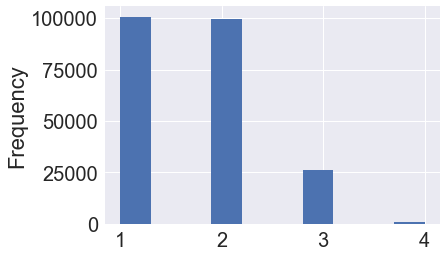

In [117]:
df2['nb_genre'].plot(kind='hist')

So we see that the majority of the songs have 1 or 2 different genres, some also have 3 genres and 4 genres is atypical. We can now drop the 6 columns containing the label genres.

In [118]:
df2 = df2.drop(columns=genres_cols)

Now for each genre we plot the number of samples per year.

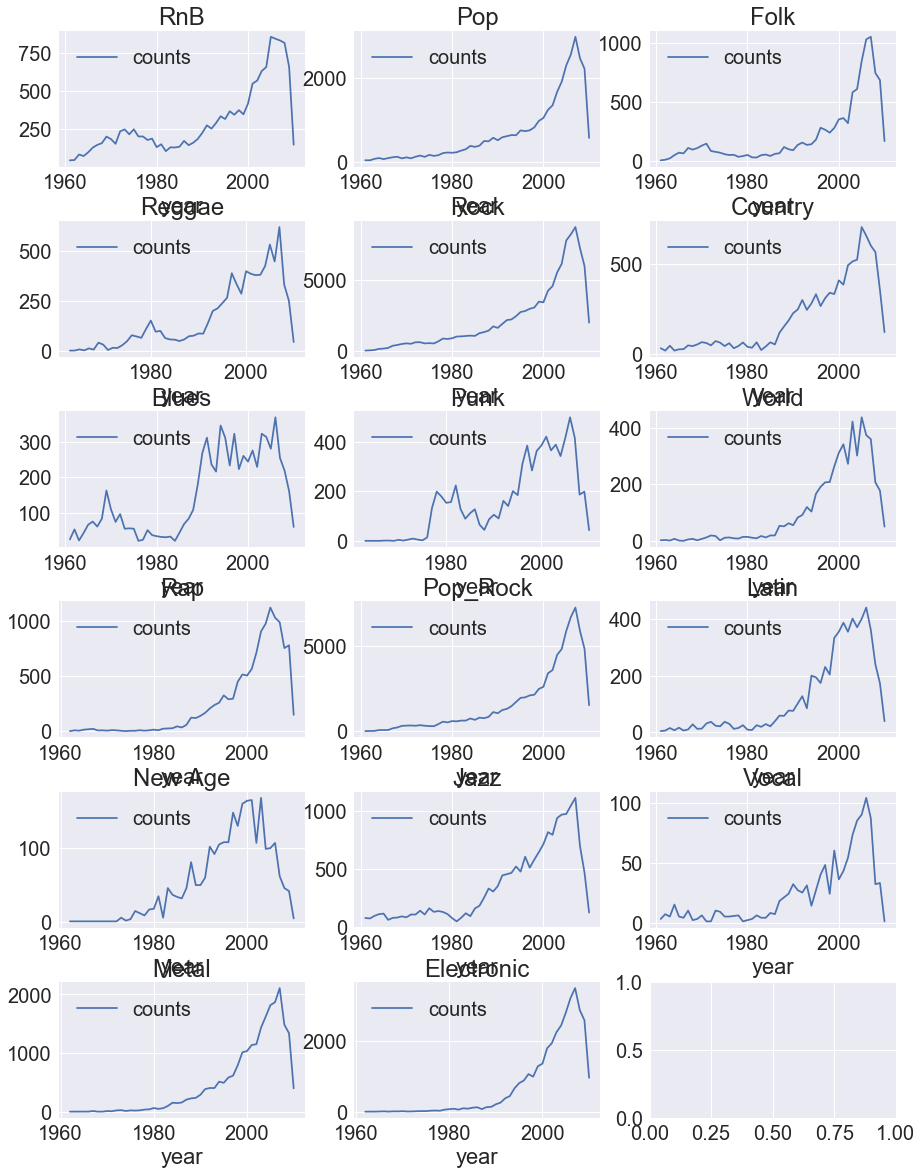

In [119]:
int(len(list(genres))/3.0 + .5)
f, axarr = plt.subplots(int(len(list(genres))/3.0 + .5), 3)
f.set_size_inches(15, 20)
plt.subplots_adjust(hspace=.4)
i = 0
all_data = {}
for genre in genres:
    data_genre = df2[df2[genre] == 1].groupby(['year']).size().reset_index(name='counts')
    data_genre.plot(x='year', y='counts', kind='line', title=genre, ax=axarr[int(i/3), i%3])
    fig = axarr[int(i/3), i%3].get_figure()
    extent = axarr[int(i/3), i%3].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    data = {}
    data['years'] = list(data_genre['year'].astype(str).values)
    data['count'] = list(data_genre['counts'].values)
    all_data[genre] = data
    #fig.savefig('figures/%s_distri_year.png' % (genre), bbox_inches=extent.expanded(1.2, 1.15), dpi = 500)
    i+=1
f = open('counts.json','w')
f.write(str(all_data))
f.close()

These plots are useful to see the data we have in our hands. 

Firstly we observe that most of the music we have is rock, pop, pop_rock, electronic or metal. On the opposite World, Latin, blues are not very represented. This can be explained either because the dataset is biased or also because some genres are more popular. Indeed Latin music is sub-represented although there is a very important latin culture in the world. These observations could be made more precise by using only the total number of songs for each genre.

Secondly these plots allow us to see some trends in the evolution of the music. If we suppose the dataset is not too much biased for the genre the most represented, we can make some interesting observations. We can see that punk music suddenly appears in the middle of the 70's. Rock started in the 60's and grows exponentially since this moment. Indeed these plots are useful to tell something about when the genre appears and how it has evolved since this moment. 

Now we want to look how genres are connected, so let's construct a graph in which nodes are the genre and a connection between two genres appears when a song has both genres. The weight of the connection is given by the number of songs.

In [120]:
adj_mat_genres = np.zeros([len(genres), len(genres)])
genres = list(genres)
for i in range(len(genres)):
    for j in range(i, len(genres)):
        nb_songs = df2[(df2[genres[i]] == 1) & (df2[genres[j]] == 1)].shape[0]
        adj_mat_genres[i, j] = nb_songs
        adj_mat_genres[j, i] = nb_songs

Computing the informations for drawing the graph.

In [121]:
adj_df = pd.DataFrame(adj_mat_genres, columns=genres)

In [122]:
adj_df['genre'] = genres

In [123]:
adj_df['radius'] = (np.diag(adj_mat_genres))**.5
adj_df['id'] = range(len(adj_df))

In [124]:
adj_df[['radius', 'id', 'genre']].T.to_dict().values()

dict_values([{'radius': 120.96280420029953, 'id': 0, 'genre': 'RnB'}, {'radius': 182.94261395311918, 'id': 1, 'genre': 'Pop'}, {'radius': 102.73266277090262, 'id': 2, 'genre': 'Folk'}, {'radius': 88.12491134747314, 'id': 3, 'genre': 'Reggae'}, {'radius': 331.7755265235819, 'id': 4, 'genre': 'Rock'}, {'radius': 99.7997995989972, 'id': 5, 'genre': 'Country'}, {'radius': 85.32877591996736, 'id': 6, 'genre': 'Blues'}, {'radius': 87.39565206576354, 'id': 7, 'genre': 'Punk'}, {'radius': 71.9444229944198, 'id': 8, 'genre': 'World'}, {'radius': 109.38921336219582, 'id': 9, 'genre': 'Rap'}, {'radius': 283.6652957272003, 'id': 10, 'genre': 'Pop_Rock'}, {'radius': 76.94153624668537, 'id': 11, 'genre': 'Latin'}, {'radius': 50.80354318352215, 'id': 12, 'genre': 'New Age'}, {'radius': 131.51805959639154, 'id': 13, 'genre': 'Jazz'}, {'radius': 34.044089061098404, 'id': 14, 'genre': 'Vocal'}, {'radius': 150.03666218628032, 'id': 15, 'genre': 'Metal'}, {'radius': 184.0135864549137, 'id': 16, 'genre': '

In [125]:
import json
a = adj_df[['radius', 'id', 'genre']].T.to_dict().values()
list(a)

[{'genre': 'RnB', 'id': 0, 'radius': 120.96280420029953},
 {'genre': 'Pop', 'id': 1, 'radius': 182.94261395311918},
 {'genre': 'Folk', 'id': 2, 'radius': 102.73266277090262},
 {'genre': 'Reggae', 'id': 3, 'radius': 88.12491134747314},
 {'genre': 'Rock', 'id': 4, 'radius': 331.7755265235819},
 {'genre': 'Country', 'id': 5, 'radius': 99.7997995989972},
 {'genre': 'Blues', 'id': 6, 'radius': 85.32877591996736},
 {'genre': 'Punk', 'id': 7, 'radius': 87.39565206576354},
 {'genre': 'World', 'id': 8, 'radius': 71.9444229944198},
 {'genre': 'Rap', 'id': 9, 'radius': 109.38921336219582},
 {'genre': 'Pop_Rock', 'id': 10, 'radius': 283.6652957272003},
 {'genre': 'Latin', 'id': 11, 'radius': 76.94153624668537},
 {'genre': 'New Age', 'id': 12, 'radius': 50.80354318352215},
 {'genre': 'Jazz', 'id': 13, 'radius': 131.51805959639154},
 {'genre': 'Vocal', 'id': 14, 'radius': 34.044089061098404},
 {'genre': 'Metal', 'id': 15, 'radius': 150.03666218628032},
 {'genre': 'Electronic', 'id': 16, 'radius': 18

In [126]:
adj_df = adj_df.iloc[:, :-3]

In [127]:
adj = adj_df.values

In [128]:
edges = []
for i in range(len(adj)):
    for j in range(i+1, len(adj)):
        edge = {'source_id': i, 'target_id': j, 'stroke_width': adj[i, j]/1000}
        edges.append(edge)
edges

[{'source_id': 0, 'stroke_width': 2.3050000000000002, 'target_id': 1},
 {'source_id': 0, 'stroke_width': 0.029999999999999999, 'target_id': 2},
 {'source_id': 0, 'stroke_width': 0.11600000000000001, 'target_id': 3},
 {'source_id': 0, 'stroke_width': 1.6299999999999999, 'target_id': 4},
 {'source_id': 0, 'stroke_width': 0.035999999999999997, 'target_id': 5},
 {'source_id': 0, 'stroke_width': 0.33900000000000002, 'target_id': 6},
 {'source_id': 0, 'stroke_width': 0.0030000000000000001, 'target_id': 7},
 {'source_id': 0, 'stroke_width': 0.091999999999999998, 'target_id': 8},
 {'source_id': 0, 'stroke_width': 0.78500000000000003, 'target_id': 9},
 {'source_id': 0, 'stroke_width': 2.0489999999999999, 'target_id': 10},
 {'source_id': 0, 'stroke_width': 0.062, 'target_id': 11},
 {'source_id': 0, 'stroke_width': 0.0080000000000000002, 'target_id': 12},
 {'source_id': 0, 'stroke_width': 1.2729999999999999, 'target_id': 13},
 {'source_id': 0, 'stroke_width': 0.035999999999999997, 'target_id': 14

Computing data points for hotness conditionnaly to the different genres. We use very little random forest to smooth the curves.

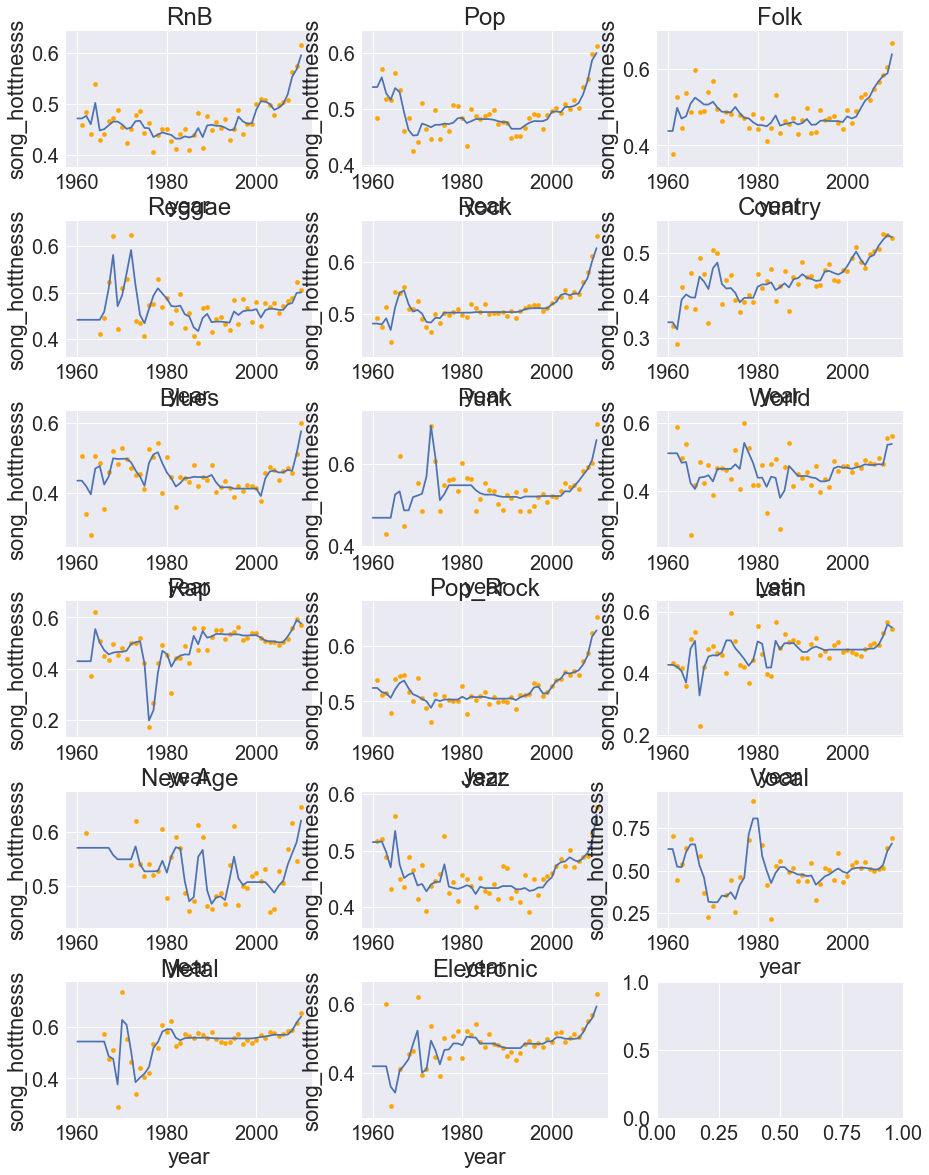

In [130]:
int(len(list(genres))/3.0 + .5)
f, axarr = plt.subplots(int(len(list(genres))/3.0 + .5), 3)
f.set_size_inches(15, 20)
plt.subplots_adjust(hspace=.4)
i = 0
all_data = {}

# Compute the avg hotness by year for all the data
hottness_avg = df2[df2['song_hotttnesss'].notna()].groupby(['year']).mean().reset_index()
regr = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth= 5)
regr.fit(hottness_avg[['year']], hottness_avg['song_hotttnesss'])
hottness_predict = regr.predict(np.array(list(range(1960, 2011))).reshape(-1, 1))
data = {}
data['years'] = list(hottness_avg['year'].astype(str).values)
data['hottness'] = list(hottness_avg['song_hotttnesss'].values)
data['predict'] = list(hottness_predict)
all_data['avg'] = data

# Compute it for each genre
for genre in genres:
    regr = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth= 5)
    hottness = df2[(df2[genre] == 1) & df2['song_hotttnesss'].notna()].groupby(['year']).mean().reset_index()
    hottness = hottness[hottness['song_hotttnesss'] > 0]
    regr.fit(hottness[['year']], hottness['song_hotttnesss'])
    hottness.plot(x='year', y='song_hotttnesss', kind='scatter', title=genre, ax=axarr[int(i/3), i%3], color='orange')
    hottness_predict = regr.predict(np.array(list(range(1960, 2011))).reshape(-1, 1))
    axarr[int(i/3), i%3].plot(list(range(1960, 2011)), hottness_predict)
    data = {}
    data['years'] = list(hottness['year'].astype(str).values)
    data['hottness'] = list(hottness['song_hotttnesss'].values)
    data['predict'] = list(hottness_predict)
    all_data[genre] = data
    i+=1
f = open('hottness.json','w')
f.write(str(all_data))
f.close()

Store data points for some interesting features evolution over years conditionnaly to the genre of song. Looking also at the average values

In [133]:
from sklearn.ensemble import RandomForestRegressor

for col in ['song_hotttnesss', 'duration', 'speechiness', 'acousticness', 'instrumentalness']:
    all_data = {}

    # Compute the avg hotness by year for all the data
    avg = df2[df2[col].notna()].groupby(['year']).mean().reset_index()
    regr = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth= 5)
    regr.fit(hottness_avg[['year']], avg[col])
    predict = regr.predict(avg['year'].values.reshape(-1, 1))
    data = {}
    data['years'] = list(avg['year'].astype(str).values)
    data[col] = list(avg[col].values)
    data['predict'] = list(predict)
    all_data['avg'] = data

    # Compute it for each genre
    print("%s: " % col)
    for genre in genres:
        regr = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth= 5)
        datas = df2[(df2[genre] == 1) & df2[col].notna()]
        col_data = datas.groupby(['year']).mean().reset_index()
        col_data = col_data[col_data[col] > 0]
        regr.fit(col_data[['year']], col_data[col])
        predict = regr.predict(hottness_avg['year'].values.reshape(-1, 1))
        data = {}
        data['years'] = list(hottness['year'].astype(str).values)
        data[col] = list(col_data[col].values)
        data['predict'] = list(predict)
        all_data[genre] = data
        i+=1
        avg += np.mean(col_data[col].values)
        print("\t %s: Nb songs = %d and Avg Value is %f" % (genre, len(datas), np.mean(data[col])))
    f = open('datastory/data/genre_analysis/%s.json' % col,'w')
    f.write(str(all_data))
    f.close()

song_hotttnesss: 
	 RnB: Nb songs = 10262 and Avg Value is 0.468802
	 Pop: Nb songs = 23884 and Avg Value is 0.493620
	 Folk: Nb songs = 7973 and Avg Value is 0.491387
	 Reggae: Nb songs = 5476 and Avg Value is 0.468608
	 Rock: Nb songs = 84322 and Avg Value is 0.516160
	 Country: Nb songs = 7043 and Avg Value is 0.440195
	 Blues: Nb songs = 4640 and Avg Value is 0.448301
	 Punk: Nb songs = 5867 and Avg Value is 0.539737
	 World: Nb songs = 3861 and Avg Value is 0.462067
	 Rap: Nb songs = 8949 and Avg Value is 0.486166
	 Pop_Rock: Nb songs = 63017 and Avg Value is 0.522481
	 Latin: Nb songs = 4204 and Avg Value is 0.469819
	 New Age: Nb songs = 2048 and Avg Value is 0.530071
	 Jazz: Nb songs = 11926 and Avg Value is 0.458473
	 Vocal: Nb songs = 845 and Avg Value is 0.501564
	 Metal: Nb songs = 18093 and Avg Value is 0.542606
	 Electronic: Nb songs = 25607 and Avg Value is 0.487382
duration: 
	 RnB: Nb songs = 14632 and Avg Value is 243.891506
	 Pop: Nb songs = 33468 and Avg Value is 22

# Feature analysis 2004-2009



In [93]:
df = pd.read_csv('final_merge.csv')

As said before, we will concentrate on the years with the most samples, meaning 2004 to 2009, a 5 year period. The analysis / procedure will be the same as before.

In [94]:
df = df[(df['year']>2003) & (df['year']<2010)]
df.columns

Index(['Unnamed: 0', 'song_hotttnesss', 'song_id', 'artist_latitude',
       'artist_location', 'artist_longitude', 'track_id', 'loudness_x',
       'mode_x', 'tempo_x', 'key_x', 'genre1_cd2c', 'genre2_cd2c',
       'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1', 'artist_id',
       'duration', 'artist_hotttnesss', 'year', 'danceability', 'energy',
       'key_y', 'loudness_y', 'mode_y', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms',
       'track_popularity', 'album_release'],
      dtype='object')

We remove the useless columns

In [95]:
df_stage1 = df.drop(['Unnamed: 0', 'artist_latitude', 'artist_location', 'artist_id', 'artist_longitude', 'song_id', 'track_id', 'artist_hotttnesss', 'mode_x', 'mode_y'], axis=1)

We one-hot encode the genres

In [96]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df_stage1[col_name].unique())
print(genres)
print(len(genres))

{nan, nan, 'RnB', 'Pop', 'Folk', 'Country', 'Rock', 'Blues', 'Reggae', 'World', 'Punk', 'Rap', 'Pop_Rock', 'Latin', 'New Age', 'Jazz', 'Vocal', 'Metal', 'Electronic', 'International'}
20


In [97]:
df_stage1[genres_cols] = df_stage1[genres_cols].fillna('Unknown')
df_stage1[genres_cols] = df_stage1[genres_cols].replace('International', 'World')

In [98]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df_stage1[col_name].unique())
    df_stage1[col_name] = df_stage1[col_name].astype(str)
print(genres)
print(len(genres))

{'RnB', 'Pop', 'Unknown', 'Folk', 'Country', 'Rock', 'Blues', 'Reggae', 'World', 'Punk', 'Rap', 'Pop_Rock', 'Latin', 'New Age', 'Jazz', 'Vocal', 'Metal', 'Electronic'}
18


In [99]:
for genre in list(genres):
    df_stage1[genre] = 0
    for col_name in genres_cols:
        df_stage1.loc[df_stage1[col_name] == genre, genre] = 1
df_stage1.drop(columns=['Unknown'], axis=1, inplace=True)
genres.remove('Unknown')

In [ ]:
plot_corr(df_stage2[df_stage2.year != 0][df_stage2.columns[0:-17]], "../datastory/figures/correlationComplete0409.png")

This looks pretty much the same as before.

In [ ]:
df_stage3 = df_stage2.drop(['album_release', 'track_popularity', 'duration_ms', 'key_y', 'loudness_y'], axis=1)
df_stage3.rename(columns={'key_x': 'key', 'loudness_x': 'loudness'}, inplace=True)

In [ ]:
plot_corr(df_stage3[df_stage3.year != 0][df_stage3.columns[0:-17]], "../datastory/figures/correlationReduce0409.png")

In [ ]:
plot_corr(pd.concat([df_stage3[['song_hotttnesss']],df_stage3[df_stage3.columns[-17:]]], axis=1), "../datastory/figures/correlationGenre0409.png")

In [ ]:
from sklearn.externals import joblib
COMPUTE = True

if COMPUTE:
    
    regressor = RandomForestRegressor(n_jobs=4, n_estimators = 400, verbose=True)

    df_stage4 = df_stage3.copy().dropna(subset=['song_hotttnesss'])

    train_set = df_stage4.drop(['song_hotttnesss'], axis=1)
    train_set = train_set.fillna(-1)

    train_label = df_stage4.song_hotttnesss

    regressor.fit(train_set, train_label)
    
    joblib.dump(regressor, 'regressor04_09.pkl')
    
else:
    
    regressor = joblib.load('regressor04_09.pkl') 

In [ ]:
genre_sum = 0.0
for a, b in sorted(zip(regressor.feature_importances_, train_set.columns), reverse=True):
    print(a, " : ", b)
    if b in genres:
        genre_sum += a
        
genre_sum

In [ ]:
feature_importance_df = pd.DataFrame({'label': train_set.columns, 'feature_importance' : regressor.feature_importances_})
order = np.flipud(feature_importance_df.sort_values(by='feature_importance').label)

In [ ]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(20,20))

snsplot = sns.barplot(x='feature_importance', y='label', data=feature_importance_df, palette="Blues_d", order=order)

snsplot.figure.savefig("../datastory/figures/RandomForest_feature_importance0409.png")

Now year has dropped quite some ranks, but is still sixth. As said before, the year has a huge impact due to the hotness degradation, meaning that 2009 songs have a naturally higher hotness than 2004 ones.

Otherwise, the distribution stays the same.